In [1]:
import os, sys, glob, json
import librosa
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 1

# Sanity check on web-scraped TSV files

In [6]:
tsv_files = glob.glob("../data/tsv/*/*.tsv")
num_lines = lambda x: sum(1 for line in open(x))

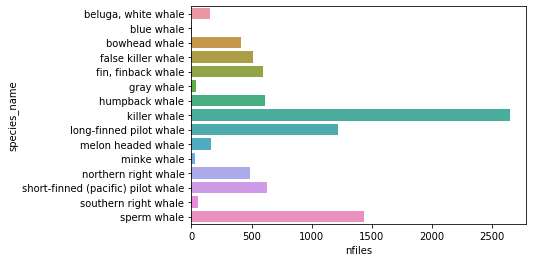

In [26]:
# Quick check on number of files
file_stats = {"species_name":[],"year":[],"nfiles":[]}
for file in tsv_files:
    file_stats["species_name"].append(os.path.basename(os.path.dirname(file)))
    file_stats["year"].append(file.rsplit('_',1)[1].split('.')[0])
    file_stats["nfiles"].append(num_lines(file))
df = pd.DataFrame.from_dict(file_stats)
counts = df.groupby("species_name").sum()
sns.barplot(x='nfiles',y='species_name',data=counts.reset_index())

In [114]:
# Join all TSV files and metadata
tsv_files = glob.glob("../data/tsv/killer whale/*.tsv")
df_list = []
for tsv_file in tsv_files:
    df_list.append(pd.read_csv(tsv_file,sep='\t'))
df = pd.concat(df_list)

In [ ]:
# for ref see pg. 20 here https://cis.whoi.edu/science/B/whalesounds/WHOI-92-31.pdf 
# cols to join: RN, CU, SR, CS
with open("../data/tsv/killer whale/metadata.json") as f: metadata = json.load(f)
mtd_df = pd.DataFrame.from_dict(metadata,orient="index")
mtd_df = mtd_df.fillna(0).astype({"SR":int,"CS":float},errors="ignore")
df = pd.DataFrame.merge(df,mtd_df[["RN","CU","SR","CS"]],left_on="metadata",right_index=True)
df["wav_id"] = df.RN.apply(lambda x: x[:5])

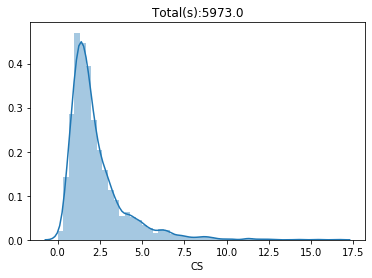

In [107]:
total_s = df.CS.sum()
plt.title("Total(s):"+str(round(total_s)))
sns.distplot(df.CS)

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(y="wav_id",x="CU",data=df.groupby("wav_id").CU.count().reset_index(),orient="h")

In [137]:
df.to_csv("../data/tsv/killer whale/allcuts.tsv",sep='\t',index=False)

# Dataloader Scratch

In [3]:
%aimport dataloader
from IPython.display import display, Audio

In [4]:
time_to_s = lambda x: x.hour*3600+x.minute*60+x.second+x.microsecond/1e6
def parse_cut_time(x):
    xs = x.split()
    if len(xs)==1:
        return float(xs[0])
    else:
        if xs[1][0]=='B':
            try:
                t1 = pd.to_datetime(xs[1][1:],format="%M:%S.%f").time()
                t2 = pd.to_datetime(xs[2],format="%M:%S.%f").time()
            except Exception:
                t1 = pd.to_datetime(xs[1][1:],format="%M:%S").time()
                t2 = pd.to_datetime(xs[2],format="%M:%S.%f").time()
            return time_to_s(t1) if t1<t2 else time_to_s(t2)

def prepare_allcuts_df(df,master_wav_ids):
    df = df.copy()
    df['start_time_s'] = 0.0
    df['duration_s'] = pd.to_datetime(df.CS,unit='s').dt.time.apply(time_to_s)
    df['wav_filename'] = df.audio.apply(lambda x: Path(x).stem+".wav")
    for master_wav_id in master_wav_ids:
        df.loc[
            df.wav_id==master_wav_id,'start_time_s'
        ] = df.loc[df.wav_id==master_wav_id].CU.apply(parse_cut_time)
        df.loc[
            df.wav_id==master_wav_id,'wav_filename'
        ] = df.loc[df.wav_id==master_wav_id].wav_id.apply(lambda x: str(x)+".wav")
    print("Length before dropping",len(df))
    df = df.drop_duplicates(['wav_filename','start_time_s','duration_s']).sort_values(by=['wav_filename','start_time_s'])
    print("Length after dropping",len(df))
    return df[['wav_filename','start_time_s','duration_s','location','date']].reset_index(drop=True)

In [5]:
# create TSV in final format for training data
df = pd.read_csv("../data/tsv/killer whale/allcuts.tsv",sep='\t')
master_ids = set([ int(Path(p).stem) for p in os.listdir("../data/wavmaster/") if len(Path(p).stem)==5 ])
df = prepare_allcuts_df(df,master_ids)
df.to_csv("../train_data/train.tsv",sep='\t',index=False)

Length before dropping 2647
Length after dropping 2639


In [6]:
df.head()

,wav_filename,start_time_s,duration_s,location,date
0,60012.wav,34.126,2.918,"Dabob Bay, Seattle, Washington",28-Oct-1960
1,60012.wav,36.816,2.588,"Dabob Bay, Seattle, Washington",28-Oct-1960
2,60012.wav,42.550,2.055,"Dabob Bay, Seattle, Washington",28-Oct-1960
3,60012.wav,44.606,2.410,"Dabob Bay, Seattle, Washington",28-Oct-1960
4,60012.wav,46.636,3.425,"Dabob Bay, Seattle, Washington",28-Oct-1960


In [7]:
# select one wavfile for now
wav_filename = "60026.wav"
df1 = df[df.wav_filename==wav_filename].copy()

267 positive windows out of 425


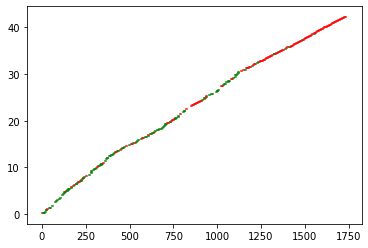

In [8]:
wm = dataloader.WavMasterFile("../train_data/wav/{}".format(wav_filename),df1.start_time_s,df1.duration_s,5)
positive_idxs = [ i for i in range(len(wm.windows)) if wm.windows[i][-1]==1 ]
print(len(positive_idxs),"positive windows out of",len(wm.windows))
wm.plot_for_debug('windows')

In [9]:
idx = np.random.choice(positive_idxs)
sample, label = wm[idx]
print("Idx:",idx,"Label",label)
Audio(sample,rate=wm.sr)

Idx: 358 Label 1


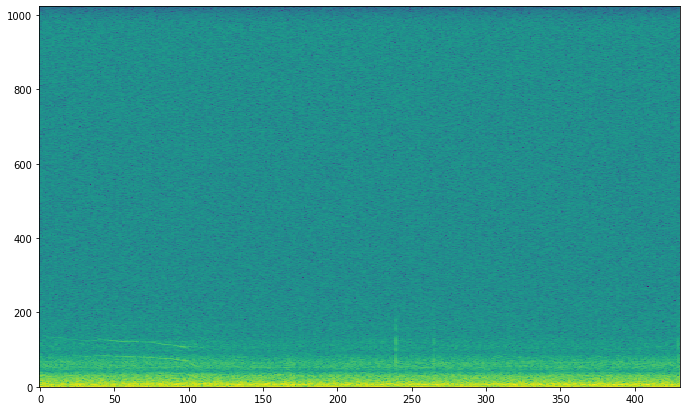

In [10]:
spec = np.log(np.abs(librosa.core.stft(sample)))[1:,:]
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.imshow(spec,origin='lower')
ax.set_aspect(0.25)